# Brief Explanation
In this notebook we are preprocessing images from HIBA in order to test our algorithm and compare its results to the ones of a prexsiting one.
Images are annotated by the use of masks (boxes in the csv correspond to just one of the classes mentioned), so the main function here transforms those masks into bounding boxes by selecting the min and max pixels part of a certain mask in both axes (x and y). It is important to notice that there are no masks for the class "NoFinding".

# Mounting & Importing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil, os
import zipfile
import pandas as pd
import numpy as np
from os.path import isfile, join
from glob import glob
import yaml
from tqdm.notebook import tqdm

# Unzipping

In [ ]:
dir = '/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2'
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/Euge_v2.zip', 'r')
zip_ref.extractall(path=dir)
zip_ref.close()

# Annotations

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/test_hibav2.csv')
df

,file_name,class_name,height,width,x1,x2,y1,y2,label_level
0,b4ef5c3ea6b611ebabb6f48e3885516d,Consolidacion,3054,3056,838.0,1384.0,869.0,1627.0,mask
1,b4f2b7a8a6b611ebac95f48e3885516d,NoduloMasa,2735,2802,489.0,909.0,1313.0,1629.0,mask
2,b4f2b7a9a6b611ebb8abf48e3885516d,Consolidacion-Consolidacion,2544,3056,852.0,1493.0,763.0,1961.0,mask
3,b4f2b7aaa6b611ebb118f48e3885516d,Consolidacion,2364,3008,854.0,1467.0,840.0,1764.0,mask
4,b4f2b7aba6b611eb8759f48e3885516d,Consolidacion,2500,2048,349.0,773.0,636.0,1131.0,mask
...,...,...,...,...,...,...,...,...,...
1325,b4f7e7e8a6b611eb9da7f48e3885516d,NaN,2342,2928,NaN,NaN,NaN,NaN,nofinding
1326,b4f7e7e9a6b611eb8c44f48e3885516d,NaN,2314,2360,NaN,NaN,NaN,NaN,nofinding
1327,b4f7e7eaa6b611eb8699f48e3885516d,NaN,2540,3056,NaN,NaN,NaN,NaN,nofinding
1328,b4f7e7eba6b611ebb13bf48e3885516d,NaN,2544,3056,NaN,NaN,NaN,NaN,nofinding


# Obtaining BB

In [ ]:
# There are just masks for no null classes
df2 = df[~df.class_name.isnull()]

In [6]:
class_numbers = {#'Background':0,
 'NoduloMasa': 1,
 'Consolidacion': 2,
 'PatronIntersticial': 3,
 'Atelectasia': 4,
 'LesionesDeLaPared': 5
 }

In [ ]:
def getMaskBoxes(mask_path,list_of_labels,height,width):
    if isinstance(mask_path,str):
        # each color corresponds to a different instance with 0 being background
        with open(mask_path, 'rb') as f:
            mask = np.load(f)
        boxes = []
        labels = []
        raw_labels = [class_numbers.get(c) for c in list_of_labels.split('-')]
        # instances are encoded as different colors
        obj_ids = np.unique(mask)[1:]
        # split the color-encoded mask into a set of binary masks
        masks = mask == obj_ids[:, None, None]
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if ymax > ymin and xmax > xmin:
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(raw_labels[i])            
        df = pd.DataFrame({'boxes':boxes,'labels':labels,'image':mask_path,'height':height,'width':width})
        return df
    else:
        return None

In [ ]:
results = pd.DataFrame(columns=['boxes', 'labels', 'image','height','width'])
for index,row in df2.iterrows():
  results = results.append(getMaskBoxes('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/masks/'+row['file_name']+'.npy',row['class_name'],row['height'],row['width']))
results

,boxes,labels,image,height,width,widht
0,"[838, 869, 1384, 1627]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,3054,NaN,3056.0
0,"[489, 1313, 909, 1629]",1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2735,NaN,2802.0
0,"[852, 763, 1493, 1961]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2544,NaN,3056.0
1,"[1728, 420, 2511, 1659]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2544,NaN,3056.0
0,"[854, 840, 1467, 1764]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2364,NaN,3008.0
...,...,...,...,...,...,...
2,"[54, 989, 202, 1550]",5,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2048,NaN,2500.0
0,"[1371, 711, 2349, 2076]",1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,3056,NaN,2544.0
0,"[1803, 594, 2010, 1145]",4,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2364,NaN,2880.0
0,"[1598, 889, 1899, 1165]",1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2048,NaN,2500.0


# Visualize Results
draft

In [3]:
fds = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/boxes.csv')
fds

,Unnamed: 0,boxes,labels,image,height,width,class
0,0,"[838, 869, 1384, 1627]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,3054,3056.0,Consolidation
1,0,"[489, 1313, 909, 1629]",1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2735,2802.0,Consolidation
2,0,"[852, 763, 1493, 1961]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2544,3056.0,Consolidation
3,1,"[1728, 420, 2511, 1659]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2544,3056.0,Consolidation
4,0,"[854, 840, 1467, 1764]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2364,3008.0,Consolidation
...,...,...,...,...,...,...,...
370,2,"[54, 989, 202, 1550]",5,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2048,2500.0,Consolidation
371,0,"[1371, 711, 2349, 2076]",1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,3056,2544.0,Consolidation
372,0,"[1803, 594, 2010, 1145]",4,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2364,2880.0,Consolidation
373,0,"[1598, 889, 1899, 1165]",1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2048,2500.0,Consolidation


In [7]:
r_dictionary = {value : key for (key, value) in class_numbers.items()}


In [11]:
fds['labels_c'] = fds.labels.replace(r_dictionary)

In [13]:
fds.groupby(['labels_c'])['image'].count()

labels_c
Atelectasia            25
Consolidacion          64
LesionesDeLaPared      34
NoduloMasa             98
PatronIntersticial    154
Name: image, dtype: int64

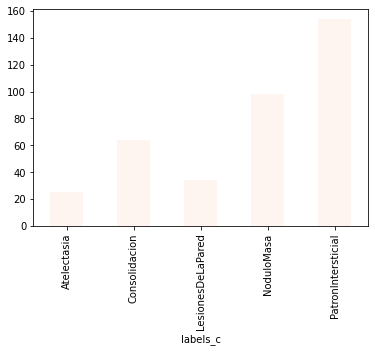

In [12]:
fds.groupby(['labels_c'])['image'].count().plot(kind='bar',colormap='Reds')

In [ ]:
fds['file_name'] = fds.image.str.split('/').str[-1].str.split('.').str[0]
fds.head()

,Unnamed: 0,boxes,labels,image,height,width,class,file_name
0,0,"[838, 869, 1384, 1627]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,3054,3056.0,Consolidation,b4ef5c3ea6b611ebabb6f48e3885516d
1,0,"[489, 1313, 909, 1629]",1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2735,2802.0,Consolidation,b4f2b7a8a6b611ebac95f48e3885516d
2,0,"[852, 763, 1493, 1961]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2544,3056.0,Consolidation,b4f2b7a9a6b611ebb8abf48e3885516d
3,1,"[1728, 420, 2511, 1659]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2544,3056.0,Consolidation,b4f2b7a9a6b611ebb8abf48e3885516d
4,0,"[854, 840, 1467, 1764]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2364,3008.0,Consolidation,b4f2b7aaa6b611ebb118f48e3885516d


In [ ]:
fds['class_name'] = fds['class']


In [ ]:
fds[fds['file_name'] == fds['file_name'].values[0]]

,Unnamed: 0,boxes,labels,image,height,width,class,file_name,class_name
0,0,"[838, 869, 1384, 1627]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,3054,3056.0,Consolidation,b4ef5c3ea6b611ebabb6f48e3885516d,Consolidation


In [ ]:
def visualize_plot(idx):
    image = fds['file_name'].values[idx]
    records = fds[fds['file_name'] == image]
    boxes = np.array(records[['x_min','y_min','x_max','y_max']])
    
    labels = records.class_name
    sample = imread(os.path.join('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/','train',f'{image}.jpg'))
    img = cv2.cvtColor(sample,cv2.COLOR_GRAY2RGB)#[sample,sample,sample]#.copy()
    plt.figure(figsize=(12, 12))
    for box,label in zip(boxes,labels):
        bbv.add_label(img, 
                      label, 
                      [int(round(box[0])), int(round(box[1])),int(round(box[2])), int(round(box[3]))], 
                      draw_bg=True,
                      text_bg_color=(255,0,0),
                      text_color=(0,0,0),
                        )
        cv2.rectangle(img ,
                      (int(round(box[0])), int(round(box[1]))),
                      (int(round(box[2])), int(round(box[3]))),
                      (255,0,0),
                      2)

    plt.imshow(img)
    retur(img)
    #print('BB anotation looks like:{}'.format(boxes))

In [ ]:
import numpy as np
img_array = np.load(os.path.join('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/masks/',f'{fds['image_id'].values[idx]}.npy'))
from matplotlib import pyplot as plt
#print(df.file_name[im],df['class'][im])
plt.imshow(img_array, cmap='gray')
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray') 
plt.imshow(img_array, cmap='gray', alpha=0.5)
print(df.file_name[im])

In [ ]:
visualize_plot(0)

KeyError: ignored

# a

In [ ]:
results = results.drop(['width'],axis=1)
results

,boxes,labels,image,height,widht,class
0,"[838, 869, 1384, 1627]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,3054,3056.0,Consolidation
0,"[489, 1313, 909, 1629]",1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2735,2802.0,Consolidation
0,"[852, 763, 1493, 1961]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2544,3056.0,Consolidation
1,"[1728, 420, 2511, 1659]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2544,3056.0,Consolidation
0,"[854, 840, 1467, 1764]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2364,3008.0,Consolidation
...,...,...,...,...,...,...
2,"[54, 989, 202, 1550]",5,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2048,2500.0,Consolidation
0,"[1371, 711, 2349, 2076]",1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,3056,2544.0,Consolidation
0,"[1803, 594, 2010, 1145]",4,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2364,2880.0,Consolidation
0,"[1598, 889, 1899, 1165]",1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2048,2500.0,Consolidation


In [ ]:
results = results.rename(columns = {'widht':'width'})

In [ ]:
results.to_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/boxes.csv')

# Adapt to model
The aim of this section is to adapt annotations in order to be able to run our YOLO model.  

In [ ]:
results['class'] = 'Consolidation'
results

,boxes,labels,image,height,width,class
0,"[838, 869, 1384, 1627]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,3054,3056.0,Consolidation
0,"[489, 1313, 909, 1629]",1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2735,2802.0,Consolidation
0,"[852, 763, 1493, 1961]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2544,3056.0,Consolidation
1,"[1728, 420, 2511, 1659]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2544,3056.0,Consolidation
0,"[854, 840, 1467, 1764]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2364,3008.0,Consolidation
...,...,...,...,...,...,...
2,"[54, 989, 202, 1550]",5,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2048,2500.0,Consolidation
0,"[1371, 711, 2349, 2076]",1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,3056,2544.0,Consolidation
0,"[1803, 594, 2010, 1145]",4,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2364,2880.0,Consolidation
0,"[1598, 889, 1899, 1165]",1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2048,2500.0,Consolidation


In [ ]:
fds = results

In [ ]:
# Normalizing Annotations 

# BB Normalized Limits
fds['x_min'] = fds.apply(lambda row: (row.boxes[0])/row.width, axis =1)
fds['y_min'] = fds.apply(lambda row: (row.boxes[1])/row.height, axis =1)

fds['x_max'] = fds.apply(lambda row: (row.boxes[2])/row.width, axis =1)
fds['y_max'] = fds.apply(lambda row: (row.boxes[3])/row.height, axis =1)

# BB Normalized Center
fds['x_mid'] = fds.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
fds['y_mid'] = fds.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

# BB Nomalized With & Height
fds['w'] = fds.apply(lambda row: (row.x_max-row.x_min), axis =1)
fds['h'] = fds.apply(lambda row: (row.y_max-row.y_min), axis =1)

# BB as a % area of the image
fds['area'] = fds['w']*fds['h']
fds.head()

,boxes,labels,image,height,width,class,x_min,y_min,x_max,y_max,x_mid,y_mid,w,h,area
0,"[838, 869, 1384, 1627]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,3054,3056.0,Consolidation,0.274215,0.284545,0.452880,0.532744,0.363547,0.408644,0.178665,0.248199,0.044344
0,"[489, 1313, 909, 1629]",1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2735,2802.0,Consolidation,0.174518,0.480073,0.324411,0.595612,0.249465,0.537843,0.149893,0.115539,0.017319
0,"[852, 763, 1493, 1961]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2544,3056.0,Consolidation,0.278796,0.299921,0.488547,0.770833,0.383671,0.535377,0.209751,0.470912,0.098774
1,"[1728, 420, 2511, 1659]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2544,3056.0,Consolidation,0.565445,0.165094,0.821662,0.652123,0.693554,0.408608,0.256217,0.487028,0.124785
0,"[854, 840, 1467, 1764]",2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,2364,3008.0,Consolidation,0.283910,0.355330,0.487699,0.746193,0.385805,0.550761,0.203790,0.390863,0.079654


In [ ]:
fds.to_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/norm_boxes.csv')

In [ ]:
fds = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/norm_boxes.csv')

In [ ]:
fds.image.to_numpy()[0].split('/')[-1].split('.')[0]

'b4ef5c3ea6b611ebabb6f48e3885516d'

In [ ]:
os.makedirs('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/labels/test', exist_ok = True)
os.makedirs('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/images/test', exist_ok = True)

In [ ]:
for file in tqdm(df.file_name.to_numpy()):
  shutil.copy('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/images/'+file+'.jpg','/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/images/test')

In [ ]:
def create_labels():
  label_dir = '/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/labels/test/' 
  for image in tqdm(df.file_name.to_numpy()):
    my_list = []
    for index, row in fds.iterrows():
      if(image == row['image'].split('/')[-1].split('.')[0]):
       if(row['class']=='Consolidation'): 
         my_list.append('0' + '\t' + str(row['x_mid']) + '\t' + str(row['y_mid']) + '\t' + str(row['w']) + '\t' + str(row['h']) + '\n')
    filename = image.split('.')[0]
    file1 = open(os.path.join(label_dir, filename+'.txt'),"w") 
    file1.writelines(np.unique(my_list))
    file1.close()

In [ ]:
create_labels()

# Prepare for Test

In [ ]:
cwd = '/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/'

# Create a .txt with the paths of each and every single image in the DS
with open(join(cwd,'test.txt'), 'w') as f:
    for path in glob('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/images/test/*'):
        f.write(path+'\n')            


data = dict(
    test = join(cwd,'test.txt'),
    nc    = 1,
    names = ['Consolidation']
)


In [ ]:
with open(join( cwd , 'test_HIBA.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join( cwd , 'test_HIBA.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Consolidation
nc: 1
test: /content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/test.txt



# Test

In [ ]:
# Change WD
os.chdir( '/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/yolov5')

In [ ]:
# install dependencies
%pip install -qr requirements.txt
%pip install -r requirements.txt wandb  

     |████████████████████████████████| 645kB 8.8MB/s 
     |████████████████████████████████| 2.1MB 8.0MB/s 
     |████████████████████████████████| 163kB 39.6MB/s 
     |████████████████████████████████| 102kB 8.5MB/s 
     |████████████████████████████████| 133kB 39.8MB/s 
     |████████████████████████████████| 71kB 7.0MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=08e85f9580b92d7cfd2341b4d9b08db5daeaf3aa10b096f74af76bdb7341f259
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=99f2a16e546573433c81cd17342751e01fa63073d49ff2d9a70047d1cee9bd5e
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [ ]:
import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu101 CPU


In [ ]:
!python test.py --weights /content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/yolov5/runs/train/exp12/weights/best.pt --data /content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/test_HIBA.yaml --img 640 --task test

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/test_HIBA.yaml', device='', exist_ok=False, img_size=640, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='test', verbose=False, weights=['/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/yolov5/runs/train/exp12/weights/best.pt'])
YOLOv5 🚀 v4.0-138-ged2c742 torch 1.8.1+cu101 CPU

Fusing layers... 
Model Summary: 476 layers, 87198694 parameters, 0 gradients, 217.1 GFLOPS
test: Scanning '/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/test' images and labels... 1330 found, 0 missing, 1097 empty, 0 corrupted: 100% 1330/1330 [00:11<00:00, 112.08it/s]
test: New cache created: /content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/DS_VAL_OD/unzipped_v2/test.cache
   